# Ultralytics YOLO Foramt

When training object detection models using Ultralytics YOLO, the dataset must follow a specific directory structure. Each dataset split (train, valid, test) must contain separate subdirectories for images and corresponding annotation files in labels (YOLO format).

```
dataset/
├── train/
│   ├── images/
│   │   ├── img1.jpg
│   │   └── ...
│   └── labels/
│       ├── img1.txt
│       └── ...
├── valid/
│   ├── images/
│   └── labels/
├── test/
│   ├── images/
│   └── labels/
└── data.yaml

```
  
Each **.txt** file in **labels/** must meet the conditions:
- Have the same filename as its corresponding image.  
- Contain annotations in the YOLO format
- All annotations must be normalized to the [0, 1] range relative to image width and height.  
```<class_id> <x_center> <y_center> <width> <height>```

Therefore we will first copy the old images to the appropriate folders and then deal with the annotations.

# Defininig paths

In [1]:
import sys
from pathlib import Path
import os
sys.path.append(str(Path(os.getcwd()).resolve().parent))

# Path of the project
PROJECT_PATH = Path(os.getcwd()).resolve().parent

DATA_DIR = PROJECT_PATH / 'data'

TRAIN_DIR = DATA_DIR / 'train'
TRAIN_SET_DIR = TRAIN_DIR / 'images'
TRAIN_ANNOTATIONS_JSON_PATH = TRAIN_DIR / 'coco_annotations' / 'annotations.json'

VALID_DIR = DATA_DIR / 'valid'
VALID_SET_DIR = VALID_DIR / 'images'
VALID_ANNOTATIONS_JSON_PATH = VALID_DIR / 'coco_annotations' / 'annotations.json'

TEST_DIR = DATA_DIR / 'test'
TEST_SET_DIR = TEST_DIR / 'images'
TEST_ANNOTATIONS_JSON_PATH = TEST_DIR / 'coco_annotations' / 'annotations.json'


# Added labels folder for each set
TRAIN_LABELS_DIR = TRAIN_DIR / 'labels'
TRAIN_LABELS_DIR.mkdir(parents=True, exist_ok=True)

VALID_LABELS_DIR = VALID_DIR / 'labels'
VALID_LABELS_DIR.mkdir(parents=True, exist_ok=True)

TEST_LABELS_DIR = TEST_DIR / 'labels'
TEST_LABELS_DIR.mkdir(parents=True, exist_ok=True)

# Dataset conversion

The annotation class indices we used to train transformer-based models started from 1, because several of these models require index 0 to refer to the background. This is due to the architecture and the way these models work.  
  
YOLO models require class indexes to start at 0, so the following function also reduces all indexes by 1. 

In [37]:
from utils.data_utils.load_dataset import LoadDataset
from tqdm import tqdm

def json2img_txt_format(dataset: LoadDataset, dst_folder: Path) -> None:
    for _, target in tqdm(dataset, total=len(dataset), desc=f'Saving YOLO annotations to {dst_folder}'):
        img_filename = Path(target['image_path']).stem
        label_img_path = dst_folder / f'{img_filename}.txt'

        with open(label_img_path, 'x') as f:
            cls_ids = [ann['category_id'] for ann in target['annotations']]
            bboxes = [ann['bbox'] for ann in target['annotations']]
            for class_id, bbox in zip(cls_ids, bboxes):
                f.write(f'{int(class_id-1)} {float(bbox[0])} {float(bbox[1])} {float(bbox[2])} {float(bbox[3])}\n')

In [38]:
import importlib
import utils.data_utils.load_dataset
importlib.reload(utils.data_utils.load_dataset)
from utils.data_utils.load_dataset import LoadDataset

train_dataset = LoadDataset(
    TRAIN_SET_DIR,
    TRAIN_ANNOTATIONS_JSON_PATH,
    desire_bbox_format='cxcywh',
    return_img_path=True
)
valid_dataset = LoadDataset(
    VALID_SET_DIR,
    VALID_ANNOTATIONS_JSON_PATH,
    desire_bbox_format='cxcywh',
    return_img_path=True
)
test_dataset = LoadDataset(
    TEST_SET_DIR,
    TEST_ANNOTATIONS_JSON_PATH,
    desire_bbox_format='cxcywh',
    return_img_path=True
)

json2img_txt_format(train_dataset, TRAIN_LABELS_DIR)
json2img_txt_format(valid_dataset, VALID_LABELS_DIR)
json2img_txt_format(test_dataset, TEST_LABELS_DIR)

loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Saving YOLO annotations to /home/mikolaj/Desktop/Projects/my_projects/football-ai/data/train/labels: 100%|██████████| 905/905 [00:38<00:00, 23.36it/s]
Saving YOLO annotations to /home/mikolaj/Desktop/Projects/my_projects/football-ai/data/valid/labels: 100%|██████████| 124/124 [00:05<00:00, 22.76it/s]
Saving YOLO annotations to /home/mikolaj/Desktop/Projects/my_projects/football-ai/data/test/labels: 100%|██████████| 93/93 [00:03<00:00, 25.62it/s]


## Creating data.yaml file 

YOLO models also require a data.yaml file to define the information about the dataset.  
The **data.yaml** should look like this:
```
train: <Path to training dataset>
val: <Path to validation dataset>
test: <Path to test dataset>

nc: <Number of classes>
names: <List of class labels>
```

In [40]:
DATA_YAML_PATH = DATA_DIR / 'data.yaml'

data_yaml = f'''train: {TRAIN_SET_DIR}
val: {VALID_SET_DIR}
test: {TEST_SET_DIR}

nc: 4
names: ['Ball', 'Goalkeeper', 'Player', 'Referee']
'''

with open(DATA_YAML_PATH, 'w') as f:
    f.write(data_yaml)

# Checking the annotations

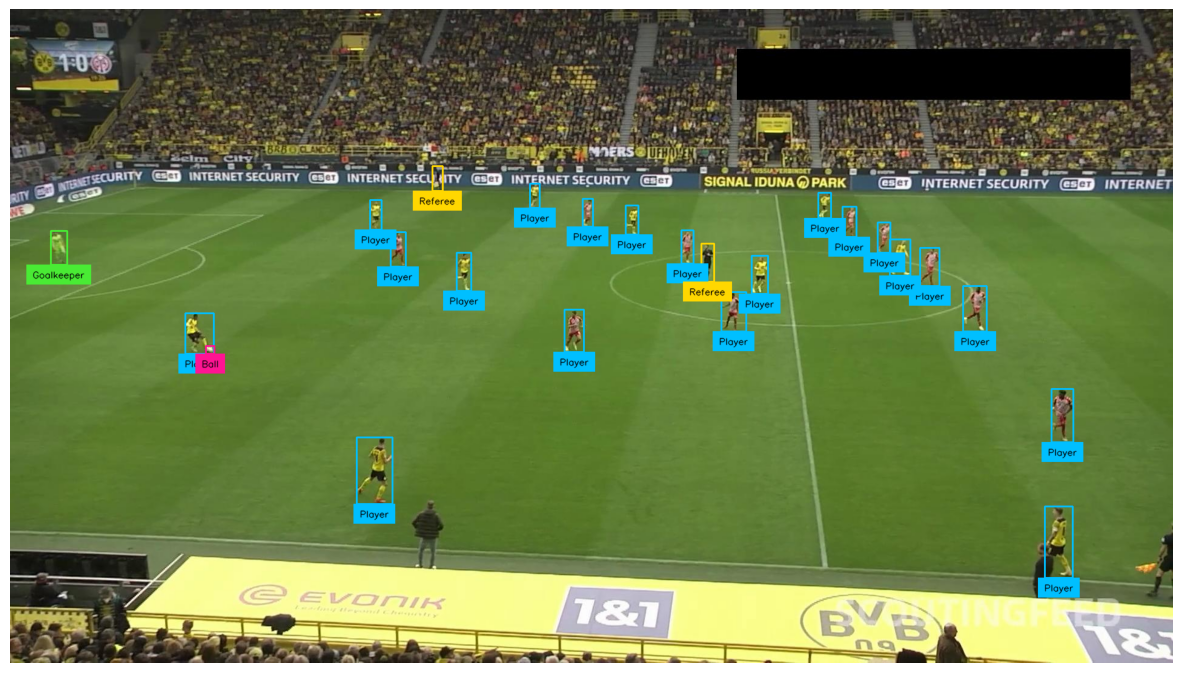

In [43]:
import cv2
import supervision as sv
import numpy as np
from utils.box_ops import cxcywh2xyxy, denormalize_bboxes

ID2LABEL = {
    0: 'Ball', 
    1: 'Goalkeeper', 
    2: 'Player', 
    3: 'Referee'
}
BOX_ANNOTATOR = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF1493', '#49eb34', '#00BFFF', '#FFD700']),
    thickness=2
)
LABEL_ANNOTATOR = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF1493', '#49eb34', '#00BFFF', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)

test_image_filename = Path('4b770a_1_4_png.rf.9cca1742bf0081e67440aa1c8b9931e3.jpg')
test_image_path = TEST_SET_DIR / test_image_filename
test_annotations_path = TEST_LABELS_DIR / f'{test_image_filename.stem}.txt'

test_img = cv2.imread(test_image_path)
img_size = test_img.shape

bboxes = []
class_ids = []
with open(test_annotations_path, 'r') as f:
    for line in f:
        line = line.split(' ')
        class_ids.append(int(line[0]))
        bboxes.append(list(map(float, line[1:])))

class_ids = np.array(class_ids)
bboxes = np.array(bboxes)
bboxes = cxcywh2xyxy(bboxes)
bboxes = denormalize_bboxes(bboxes, img_size[0], img_size[1])

detections = sv.Detections(
    xyxy=bboxes,
    class_id=class_ids
)
labels = [f'{ID2LABEL[class_id]}' for class_id in class_ids]

annotated_frame = test_img.copy()
annotated_frame = BOX_ANNOTATOR.annotate(annotated_frame, detections)
annotated_frame = LABEL_ANNOTATOR.annotate(annotated_frame, detections, labels)

sv.plot_image(annotated_frame, size=(15, 10))

As we can see in the image above all the annotations and class labels have been correctly assigned.  
  
The bounding boxes that were converted from **xcyxcwh** format to **xyxy** format and denormalized were displayed correctly, which proves that they were saved correctly in the foramt **xcyxcwh**.
The mapping starting from 0 (ID2LABEL) also proves that the decrementation of class indexes works correctly.

In [2]:
import sys
from pathlib import Path
import os
sys.path.append(str(Path(os.getcwd()).resolve().parent))

# Path of the project
PROJECT_PATH = Path(os.getcwd()).resolve().parent
DATA_DIR = PROJECT_PATH / 'data'
DATA_YAML_PATH = DATA_DIR / 'data.yaml'

!yolo task=detect mode=train model=yolo11s.pt data={str(DATA_YAML_PATH)} epochs=10 imgsz=640 plots=True

New https://pypi.org/project/ultralytics/8.3.228 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.12.3 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8104MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/home/mikolaj/Desktop/Projects/my_projects/football-ai/data/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None